# Gnocis - Tutorial
Bjørn André Bredesen, 2020

-------------------------------------

## Introduction

In addition to genes, genomes contain a variety of regulatory sequences, such as *cis*-regulatory elements (CREs). There are multiple classes of CREs, including enhancers – which enhance gene transcription –, silencers – which silence genes –, insulators – which delimit the effects of other CREs – and Polycomb/Trithorax Response Elements (PREs) – which maintain an epigenetic memory of transcription states. CREs can be identified by multiple experimental methods. A challenge with the experimental mapping of CREs is that epigenetic states of different cells will influence the results.

Machine learning enables *in silico* genome-wide prediction of *cis*-regulatory elements (CREs). In order to apply machine learning for the prediction of CREs, a variety of functionality is required, such as data preparation methods, functionality for preliminary data analysis, the bridging from DNA sequence to a format that the machine learning methods can utilize, cross-validation and genome-wide model application.

Gnocis is a package for Python 3 that facilitates reproducible and efficient analysis and modelling of regulatory DNA sequences by implementing the aforementioned functionality and making it available with short and concise syntax.

In this tutorial, we will use Gnocis to model and predict fruit fly Polycomb/Trithorax Response Elements (PREs) – regulatory elements that maintain an epigenetic memory of gene transcription states.

**Note**: Certain steps in this tutorial will require external libraries. These steps will be marked as "**Optional**". For these steps, either install the libraries specified, or skip the step.

-------------------------------------

## Data sources and references
 * ModENCODE: http://www.modencode.org/
    - Citation: https://www.nature.com/articles/459927a
 * Ensembl: ftp://ftp.ensembl.org/pub/release-100/gtf/drosophila_melanogaster/
    - Citation: https://doi.org/10.1093/nar/gkx1098
 * FlyBase: https://flybase.org/
    - Citation: https://academic.oup.com/nar/article/41/D1/D751/1051942
 * Kahn *et al.* 2014: https://doi.org/10.1371/journal.pgen.1004495.s010
    - Citation: https://doi.org/10.1371/journal.pgen.1004495
 * Enderle *et al.* 2011: Supplementary Table 3 (Supp Tabl 3.txt)
    - Citation: https://doi.org/10.1101/gr.114348.110
 * Bredesen *et al.* 2019: https://doi.org/10.1093/nar/gkz617
 * Ringrose *et al.* 2003: https://doi.org/10.1016/S1534-5807(03)00337-X

-------------------------------------

## Data preparation and preliminary analysis

To start with, we load Gnocis and set the random seed for reproducible results.

In [1]:
import gnocis as nc # Load Gnocis
nc.setSeed(12345) # Set random seed

**Optional:** Gnocis supports multiprocessing. Run the following step to enable for 12 cores, or edit to desired number of cores.

In [2]:
nc.setNCores(12) # Enable multi-core processing

We can then load a genome. Gnocis supports genomes in FASTA (plain or gzipped) and 2bit formats, loaded to memory or streamed from disk. Gnocis also supports genome annotations in Ensembl GTF format. Here, we will stream the fruit fly genome from disk and load a gene annotation.

In [3]:
Dmel = nc.genome('D. melanogaster R5')\
    .streamFASTAGZ('DmelR5.fasta.gz')\
    .loadEnsemblAnnotationGTFGZ('./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz')

For training our models, we will use PREs experimentally determined by Kahn *et al.* (2014). To this end, we load the coordinates of these PREs and extract the sequences from the genome. There are well-studied PREs around the *invected* and *vestigial* genes. For validation of our predictions, we exclude PREs from these regions from our training set.

In [4]:
Kahn2014Rgn = nc.loadGFF('Kahn2014.GFF')
Kahn2014Rgn

0,2L,5290,6289,+,1000
1,2L,594635,595634,+,1000
2,2L,1643905,1644904,+,1000
3,2L,1972530,1973529,+,1000
4,2L,2448155,2449154,+,1000
...,...,...,...,...,...
196,X,17662071,17663070,+,1000
197,X,17683194,17684193,+,1000
198,X,17695903,17696902,+,1000
199,X,18260357,18261356,+,1000
200,X,21244791,21245790,+,1000


In [5]:
invectedProximal = Dmel \
                    .gene('inv') \
                    .region \
                    .singleton() \
                    .recenter(100000)

vestigialProximal = Dmel \
                    .gene('vg') \
                    .region \
                    .singleton() \
                    .recenter(100000)

Kahn2014Seq = Kahn2014Rgn \
               .nonOverlap(invectedProximal) \
               .nonOverlap(vestigialProximal) \
               .recenter(3000) \
               .extract(Dmel)

Kahn2014Seq

0,2L:4289..7288 (+),,3000,2L:4289..7288 (+),TATTCAAGTT...TTTCCGGCAAA
1,2L:593634..596633 (+),,3000,2L:593634..596633 (+),GCCAAGTGAC...AGCTCAAAAGA
2,2L:1642904..1645903 (+),,3000,2L:1642904..1645903 (+),TGCGGCGTTT...TTGAAGGTCCT
3,2L:1971529..1974528 (+),,3000,2L:1971529..1974528 (+),ACGGAGTCCA...TTCGTTACGTT
4,2L:2447154..2450153 (+),,3000,2L:2447154..2450153 (+),CCAGACCGAA...AACTGAACTTC
...,...,...,...,...,...
191,3R:2658822...6591228 (+),,3000,3R:2658822...6591228 (+),AAAGTCAACA...AAAAGAGGCCA
192,3R:2659713...6600136 (+),,3000,3R:2659713...6600136 (+),TGCGCGTGTT...AACTGCAACAG
193,3R:2660622...6609226 (+),,3000,3R:2660622...6609226 (+),TGGTCGCTAG...AAAACAAATAA
194,3R:2673673...6739736 (+),,3000,3R:2673673...6739736 (+),ATCGGAAAGT...ACTCGGATCCG
195,3R:2688682...6889821 (+),,3000,3R:2688682...6889821 (+),GTTTCAATTT...TCGGATTGGAT


The machine learning methods that we will train in this tutorial require one or more negative (non-PRE) training sets. Gnocis implements i.i.d. nucleic acid sequence generation and N-th order Markov chains. Markov chains preserve motif enrichment (length N+1) of sequences, but do not preserve local pairing, which is known to be predictive of PREs (Ringrose *et al.* 2003). Here, we generate two sets of negatives: 1) by a Markov chain trained genome-wide (dummy genomic) and 2) by a Markov chain trained on PREs (dummy PREs). Multiple known PRE motifs are 4-mers or 5-mers (pho: "GCCAT", GAF/psq: "GAGAG", "GTGT"), so we use Markov chains of order 4. In order to reflect the high ratio of non-PREs to PREs in the genome, we generate a hundred times as many negatives as positives.

In [6]:
MCPRE = nc.MarkovChain(trainingSequences = Kahn2014Seq,
                       degree = 4)

DummyPREs = MCPRE.generateSet(
    n = 100 * len(Kahn2014Seq),
    length = len(Kahn2014Seq[0]))

In [7]:
MCGenome = nc.MarkovChain(trainingSequences = Dmel,
                          degree = 4)

DummyGenomic = MCGenome.generateSet(
    n = 100 * len(Kahn2014Seq),
    length = len(Kahn2014Seq[0]))

Generated negatives may not reflect the complexity of genomic sequences. Coding sequences are unlikely to contain *bona fide* PREs, so we include them as a third class of negatives. We extract coding sequences from the genome with the `getCDS` method, merge overlapping regions with the `flatten` method and extract them from the genome. Finally, we merge these into one sequence and take all windows from the sequence.

In [8]:
CDSSeq = Dmel \
          .getCDS() \
          .flatten() \
          .extract(Dmel)

CDSFragments = nc.sequence('CDS',
                           ''.join(s.seq for s in CDSSeq))\
                 .windows(3000, 3000)

In addition, we consider randomly selected, PcG-depleted genomic windows. To this end, we define a set of PcG markers (termed a "biomarker set" in Gnocis).

In [9]:
PcG = nc.biomarkers('PcG', [
    nc.loadGFFGZ('Pc.gff3.gz').deltaResize(1000),
    nc.loadGFFGZ('Psc.gff3.gz').deltaResize(1000),
    nc.loadGFFGZ('dRING.gff3.gz').deltaResize(1000),
    nc.loadGFFGZ('H3K27me3.gff3.gz'),
])

Then, we get sliding windows from the genome, find the subset that had low biomarker enrichment (LBME) and extract the sequences from the genome.

In [10]:
gwWin = Dmel.windowRegions(size = 3000, step = 250) \
            .filter('', lambda r: r.seq in [ '2L', '2R', '3L', '3R', '4', 'X' ])

gwWinNonPcG = PcG.LBMEs(gwWin, threshold = 0) \
                 .nonOverlap(invectedProximal) \
                 .nonOverlap(vestigialProximal)

gwWinNonPcGSeq = gwWinNonPcG.extract(Dmel) \
                            .windows(size = 3000, step = 250) # PcG.LBMEs merges overlapping windows,
                                                              # so get 3kb windows

gwWinNonPcGSeq

0,2L:0..3999...0..2999 (+),,3000,2L:0..3999...0..2999 (+),CGACAATGCA...AGAGTAGTGCC
1,2L:0..3999...0..3249 (+),,3000,2L:0..3999...0..3249 (+),CCAACATATT...TTTAGATTGCC
2,2L:0..3999...0..3499 (+),,3000,2L:0..3999...0..3499 (+),CCTCTCATTT...TCTGTCTTATA
3,2L:0..3999...0..3749 (+),,3000,2L:0..3999...0..3749 (+),TATTACCGCA...ATATGATCGCG
4,2L:0..3999...0..3999 (+),,3000,2L:0..3999...0..3999 (+),CGTATGCGAG...AGAGAGAGAGA
...,...,...,...,...,...
337837,3R:2790075...0..3249 (+),,3000,3R:2790075...0..3249 (+),TTTTTGCATA...TTTTTGGTGTA
337838,3R:2790075...0..3499 (+),,3000,3R:2790075...0..3499 (+),AGATGACAAT...TAGAGAATATG
337839,3R:2790075...0..3749 (+),,3000,3R:2790075...0..3749 (+),AGAATAGTGT...CGCCAGTGTGT
337840,3R:2790075...0..3999 (+),,3000,3R:2790075...0..3999 (+),AAATTATATT...TTTTTCAATTT
337841,3R:2790075...0..4249 (+),,3000,3R:2790075...0..4249 (+),ATACATTTTT...ATTGCAAAAAT


## Sequence features

In order to perform machine learning on our sequences, they must be mapped to a form at machine learning algorithms can utilize. This is commonly accomplished by mapping each sequence to a vector. Such a mapping is called a feature set. Gnocis provides efficient implementations of DNA sequence feature sets that can be used for analysis and machine learning. Feature sets in Gnocis are directed acyclic graphs that can be filtered, combined and transformed. This facilitates easy combination and manipulation of feature sets, including feature sets that are most efficiently extracted in bulk, such as *k*-spectra (see below).

#### DNA sequence motifs

The first PRE predictor – the PREdictor (Ringrose *et al.* in 2003) – models PREs in terms of locally paired enrichment of known motifs – short re-occuring sequence patterns. We found that the addition of the GTGT motif improved generalization of PRE sequence models (Bredesen *et al.* 2019). Gnocis supports motifs specified in IUPAC nucleotide codes and Position Weight Matrices (PWMs). Here, we will use the following set of IUPAC motifs (same as in Bredesen *et al.* 2019):

In [11]:
motifs = nc.motifs('Ringrose et al. 2003 + GTGT', [
    nc.IUPACMotif('En', 'GSNMACGCCCC', 1),
    nc.IUPACMotif('G10', 'GAGAGAGAGA', 1),
    nc.IUPACMotif('GAF', 'GAGAG', 0),
    nc.IUPACMotif('PF', 'GCCATHWY', 0),
    nc.IUPACMotif('PM', 'CNGCCATNDNND', 0),
    nc.IUPACMotif('PS', 'GCCAT', 0),
    nc.IUPACMotif('Z', 'YGAGYG', 0),
    nc.IUPACMotif('GTGT', 'GTGT', 0)
])
motifs

0,En,IUPAC,GSNMACGCCCC,1
1,G10,IUPAC,GAGAGAGAGA,1
2,GAF,IUPAC,GAGAG,0
3,PF,IUPAC,GCCATHWY,0
4,PM,IUPAC,CNGCCATNDNND,0
5,PS,IUPAC,GCCAT,0
6,Z,IUPAC,YGAGYG,0
7,GTGT,IUPAC,GTGT,0


#### Motif features

Based on a set of motifs, Gnocis can calculate the occurrence frequencies in sequences.

In [12]:
motifs.occFreq() \
      .table(Kahn2014Seq)

0,2L:4289..7288 (+),0.0000,4.0000,...,1.0000,2.0000,1.6667,2.3333
1,2L:593634..596633 (+),0.3333,1.6667,...,0.6667,3.0000,1.6667,8.0000
2,2L:1642904..1645903 (+),0.3333,0.0000,...,0.3333,2.6667,0.6667,6.3333
3,2L:1971529..1974528 (+),0.0000,1.3333,...,1.0000,4.0000,3.6667,12.0000
4,2L:2447154..2450153 (+),0.3333,0.3333,...,0.3333,1.3333,1.3333,12.6667
...,...,...,...,...,...,...,...,...
191,3R:2658822...6591228 (+),0.6667,2.6667,...,0.6667,1.3333,2.3333,11.3333
192,3R:2659713...6600136 (+),0.0000,0.6667,...,0.6667,3.0000,1.6667,6.6667
193,3R:2660622...6609226 (+),0.3333,0.6667,...,0.6667,2.3333,5.3333,11.0000
194,3R:2673673...6739736 (+),0.0000,3.0000,...,0.3333,2.0000,2.6667,8.0000
195,3R:2688682...6889821 (+),0.3333,0.0000,...,0.3333,2.0000,2.0000,8.6667


#### Converting to Pandas or Numpy

**Optional:** In order to facilitate analysis with external packages, tables can be converted to Pandas or Numpy format. The following converts the feature table to a Pandas dataframe. Conversion to Numpy can similarly be achieved using the `to_numpy()` method on the table.

**Note:** Executing the following step requires the Pandas package to be installed.

In [13]:
motifs.occFreq() \
      .table(Kahn2014Seq) \
      .to_pandas()

,Seq.,occFreq(En),occFreq(G10),occFreq(GAF),occFreq(PF),occFreq(PM),occFreq(PS),occFreq(Z),occFreq(GTGT)
0,b'2L:4289..7288 (+)',0.000000,4.000000,13.666667,1.333333,1.000000,2.000000,1.666667,2.333333
1,b'2L:593634..596633 (+)',0.333333,1.666667,5.666667,1.000000,0.666667,3.000000,1.666667,8.000000
2,b'2L:1642904..1645903 (+)',0.333333,0.000000,2.000000,0.666667,0.333333,2.666667,0.666667,6.333333
3,b'2L:1971529..1974528 (+)',0.000000,1.333333,5.333333,1.000000,1.000000,4.000000,3.666667,12.000000
4,b'2L:2447154..2450153 (+)',0.333333,0.333333,2.333333,0.000000,0.333333,1.333333,1.333333,12.666667
...,...,...,...,...,...,...,...,...,...
191,b'3R:26588229..26591228 (+)',0.666667,2.666667,4.000000,0.000000,0.666667,1.333333,2.333333,11.333333
192,b'3R:26597137..26600136 (+)',0.000000,0.666667,3.333333,0.333333,0.666667,3.000000,1.666667,6.666667
193,b'3R:26606227..26609226 (+)',0.333333,0.666667,2.000000,0.666667,0.666667,2.333333,5.333333,11.000000
194,b'3R:26736737..26739736 (+)',0.000000,3.000000,6.333333,0.000000,0.333333,2.000000,2.666667,8.000000


#### Motif enrichment analysis

The `summary` method for a feature set outputs a summary table of the features in a set of sequences.

In [14]:
motifs.occFreq() \
      .summary(Kahn2014Seq) \
      .sort('Mean', ascending = False)

7,occFreq(GTGT),Number,9.5306,3067.9274,3.9665
2,occFreq(GAF),Number,3.4881,980.5278,2.2424
6,occFreq(Z),Number,2.4830,262.9433,1.1612
5,occFreq(PS),Number,2.4439,197.2715,1.0058
1,occFreq(G10),Number,1.3469,502.1859,1.6048
3,occFreq(PF),Number,0.6650,47.2217,0.4921
4,occFreq(PM),Number,0.4337,26.5822,0.3692
0,occFreq(En),Number,0.2585,17.5692,0.3002


#### Comparison of motif enrichment in different sequence classes

It can be useful to compare sets of sequences in terms of their feature enrichment. The `diffsummary` method on feature sets outputs a comparison of feature enrichments.

In [15]:
neg = CDSSeq.sample(len(Kahn2014Seq)) # We get a random sample of CDS sequences as negatives

motifs.occFreq() \
      .diffsummary(Kahn2014Seq, neg) \
      .sort('Mean A', ascending = False)

7,occFreq(GTGT),9.5306,5.1300,3067.9274,7524.0402,0.1537,0.2808
2,occFreq(GAF),3.4881,1.2927,980.5278,1440.7109,0.0344,0.0447
6,occFreq(Z),2.4830,1.8789,262.9433,1965.5863,0.5728,2.2326
5,occFreq(PS),2.4439,3.2090,197.2715,5661.2710,1.1959,12.1720
1,occFreq(G10),1.3469,0.0320,502.1859,10.6810,21.1642,1.4376
3,occFreq(PF),0.6650,0.5204,47.2217,658.2344,0.8532,5.1525
4,occFreq(PM),0.4337,0.3495,26.5822,424.7223,0.9169,6.1034
0,occFreq(En),0.2585,0.1876,17.5692,136.5121,0.5895,2.3600


#### Motif pair features

Gnocis can also calculate the motif pair occurrence frequencies with a distance cutoff, as was used by Ringrose *et al.* (2003).

In [16]:
motifs.pairFreq(220) \
      .diffsummary(Kahn2014Seq, neg) \
      .sort('KLD(A||B)', ascending = False)

9,"pairFreq(G10, GAF, 220)",7.7058,0.0119,33863.3668,3.0945,5475.9831,4.1512
12,"pairFreq(G10, PS, 220)",1.5731,0.0036,1288.8407,0.4927,1305.9783,3.4358
10,"pairFreq(G10, PF, 220)",0.5697,0.0036,292.4915,0.4927,293.4519,2.6945
14,"pairFreq(G10, GTGT, 220)",8.9337,0.0618,41935.0266,81.0497,255.5605,2.6263
15,"pairFreq(GAF, GAF, 220)",7.7959,0.1760,21270.7256,194.3867,52.0141,1.8536
...,...,...,...,...,...,...,...
13,"pairFreq(G10, Z, 220)",3.0612,0.0000,5193.7098,0.0000,0.0000,0.0000
11,"pairFreq(G10, PM, 220)",0.2602,0.0000,146.6185,0.0000,0.0000,0.0000
8,"pairFreq(G10, G10, 220)",1.9558,0.0000,3615.3946,0.0000,0.0000,0.0000
3,"pairFreq(En, PF, 220)",0.0952,0.0000,10.6667,0.0000,0.0000,0.0000
1,"pairFreq(En, G10, 220)",0.2415,0.0000,184.7914,0.0000,0.0000,0.0000


#### *K*-spectra

If motifs are not known in advance, one can use a comprehensive set of *k*-mers (motifs of length *k*), called the *k*-spectrum kernel. The *k*-spectrum mismatch kernel facilitates more loosely defined features, by allowing for a single mismatch per *k*-mer. Gnocis includes efficient implementations of the *k*-spectrum (mismatch) feature sets.

In [17]:
nc.kSpectrum(5) \
      .diffsummary(Kahn2014Seq, neg) \
      .sort('KLD(A||B)', ascending = False)

561,GACAT,1.3895,2.3285,89.7160,11452.4255,1.9286,60.9063
103,ATGTC,1.3895,2.3285,89.7160,11452.4255,1.9286,60.9063
632,GTCGA,1.2670,2.3545,98.5822,11465.2684,1.8824,55.2787
483,TCGAC,1.2670,2.3545,98.5822,11465.2684,1.8824,55.2787
557,GAGCT,1.5051,3.2022,134.5505,13631.8298,1.8142,47.8585
...,...,...,...,...,...,...,...
682,GGGGG,1.7959,0.5259,440.9478,533.4027,0.0100,0.0115
324,TTATA,3.5034,0.5256,546.9977,537.1477,0.0083,0.0082
272,TATAA,3.5034,0.5256,546.9977,537.1477,0.0083,0.0082
273,TATAT,4.9320,0.8553,1644.2041,1717.0308,0.0053,0.0055
68,ATATA,4.9320,0.8553,1644.2041,1717.0308,0.0053,0.0055


#### Feature set transformation

The feature set system of Gnocis is flexible, and feature sets can be combined and filtered. As an example, we here combine a subset of motif pairs with all dimers.

In [18]:
(motifs.pairFreq(220).filter([1, 2, 3, 4, 5, 6]) + nc.kSpectrum(2)) \
      .diffsummary(Kahn2014Seq, neg) \
      .sort('KLD(A||B)', ascending = False)

1,"pairFreq(En, GAF, 220)",0.5578,0.0729,377.0113,57.9764,1.8173,0.5133
14,GA,110.2007,132.0016,14557.2179,163707.6298,0.7559,3.9292
13,TC,110.2007,132.0016,14557.2179,163707.6298,0.7559,3.9292
19,CT,107.6241,120.3959,13137.5344,139545.7421,0.7291,3.6357
8,AG,107.6241,120.3959,13137.5344,139545.7421,0.7291,3.6357
...,...,...,...,...,...,...,...
4,"pairFreq(En, PS, 220)",0.3724,0.1424,77.3668,135.0181,0.0651,0.0945
3,"pairFreq(En, PM, 220)",0.0748,0.0229,7.1247,11.3651,0.0471,0.0643
5,"pairFreq(En, Z, 220)",0.3622,0.0922,77.9473,66.5550,0.0071,0.0064
2,"pairFreq(En, PF, 220)",0.0952,0.0000,10.6667,0.0000,0.0000,0.0000
0,"pairFreq(En, G10, 220)",0.2415,0.0000,184.7914,0.0000,0.0000,0.0000


-------------------------------------

## Machine learning

Given our sequences and feature sets, we can train machine learning models. First, we formulate our training set by assigning labels to sequences of different classes (PREs vs. dummy genomic vs. dummy PREs vs. coding sequences).

In [19]:
labelDummyGenomic = nc.sequenceLabel('Dummy genomic', -1)
labelDummyPRE = nc.sequenceLabel('Dummy PRE', -2)
labelCDS = nc.sequenceLabel('Coding sequences', -3)
labelNonPcG = nc.sequenceLabel('Non-PcG', -4)

trainingSet = Kahn2014Seq.label(nc.positive) \
    + DummyGenomic.label(labelDummyGenomic) \
    + DummyPREs.label(labelDummyPRE) \
    + CDSFragments.label(labelCDS) \
    + gwWinNonPcGSeq.label(labelNonPcG)

trainingSet

0,2L:4289..7288 (+),Positive,3000,2L:4289..7288 (+),TATTCAAGTT...TTTCCGGCAAA
1,2L:593634..596633 (+),Positive,3000,2L:593634..596633 (+),GCCAAGTGAC...AGCTCAAAAGA
2,2L:1642904..1645903 (+),Positive,3000,2L:1642904..1645903 (+),TGCGGCGTTT...TTGAAGGTCCT
3,2L:1971529..1974528 (+),Positive,3000,2L:1971529..1974528 (+),ACGGAGTCCA...TTCGTTACGTT
4,2L:2447154..2450153 (+),Positive,3000,2L:2447154..2450153 (+),CCAGACCGAA...AACTGAACTTC
...,...,...,...,...,...
384819,3R:2790075...0..3249 (+),Non-PcG,3000,3R:2790075...0..3249 (+),TTTTTGCATA...TTTTTGGTGTA
384820,3R:2790075...0..3499 (+),Non-PcG,3000,3R:2790075...0..3499 (+),AGATGACAAT...TAGAGAATATG
384821,3R:2790075...0..3749 (+),Non-PcG,3000,3R:2790075...0..3749 (+),AGAATAGTGT...CGCCAGTGTGT
384822,3R:2790075...0..3999 (+),Non-PcG,3000,3R:2790075...0..3999 (+),AAATTATATT...TTTTTCAATTT
384823,3R:2790075...0..4249 (+),Non-PcG,3000,3R:2790075...0..4249 (+),ATACATTTTT...ATTGCAAAAAT


#### Model construction

Predictive models can be formulated with Gnocis in two different ways: through implementations of the `sequenceModel` class or by transforming feature sets into models using implementations of the `baseModel` class. Gnocis implements log-odds model construction through baseModel. Gnocis also includes wrappers for machine learning methods from Scikit-learn using `baseModel`.

The PREdictor (Ringrose *et al.* 2003) models PREs in terms of their local (distance cutoff of 220 bp) motif occurrence frequencies. The PREdictor can be formulated with Gnocis by transforming the motif set into a motif pair occurrence frequency feature set, and the feature set into a log-odds model.

In [20]:
PyPREdictor = motifs \
               .pairFreq(distCut = 219) \
               .model(nc.logOdds(
                      labelPositive = nc.positive,
                      labelNegative = labelDummyPRE)
               ) \
               .sequenceModel(name = 'PyPREdictor (M2003+GTGT)',
                              windowSize = 500, windowStep = 250)

Now, we can train our PREdictor model. We will pick a small training set, as an example.

In [21]:
# Make a training set
tpos = trainingSet.withLabel(nc.positive).sample(50)
tneg = trainingSet.withLabel(labelDummyPRE).sample(50)
tset = tpos + tneg

# Train the model
TrainedPyPREdictor = PyPREdictor.train(tset)

We can now score sequences with our PREdictor model using the `score` method. We have set the `asTable` parameter to `True` for nicer printout in the Jupyter Notebook. Setting it to `False` will output a list (without sequence names).

In [22]:
TrainedPyPREdictor.score(Kahn2014Seq, asTable = True)

0,2L:4289..7288 (+),372.8467
1,2L:593634..596633 (+),427.5533
2,2L:1642904..1645903 (+),49.0640
3,2L:1971529..1974528 (+),143.3339
4,2L:2447154..2450153 (+),91.5478
...,...,...
191,3R:2658822...6591228 (+),1037.1072
192,3R:2659713...6600136 (+),84.5245
193,3R:2660622...6609226 (+),103.6184
194,3R:2673673...6739736 (+),1271.3005
195,3R:2688682...6889821 (+),37.3349


We previously found that a derivative of the PREdictor with uniform motif pair weighting, which we termed the Dummy PREdictor (Bredesen *et al.* 2019), yields competitive generalization to the PREdictor.

In [23]:
DummyPREdictor = motifs \
               .pairFreq(distCut = 219) \
               .sum() \
               .sequenceModel(name = 'Dummy PREdictor (M2003+GTGT)',
                              windowSize = 500, windowStep = 250)

#### Cross-validation

After training models, an important step is to assess how well the models will generalize beyond the training set. This can be achieved by cross-validation, where a portion of the training set is left out during training and the model is tested using the remainder. Gnocis implements a cross-validation workbench that constructs randomly sampled training and test sets with no overlap, retrains all models on each training set and tests on each independent test set.  Gnocis finally constructs Receiver Operating Characteristic (ROC) and Precision/Recall (PR) curves and calculate the area under them (AUC).

Cross-validation
 - Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; S

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 1000
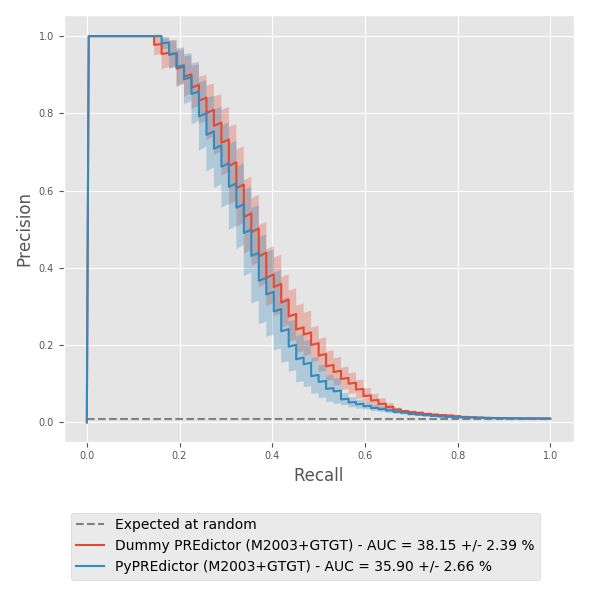
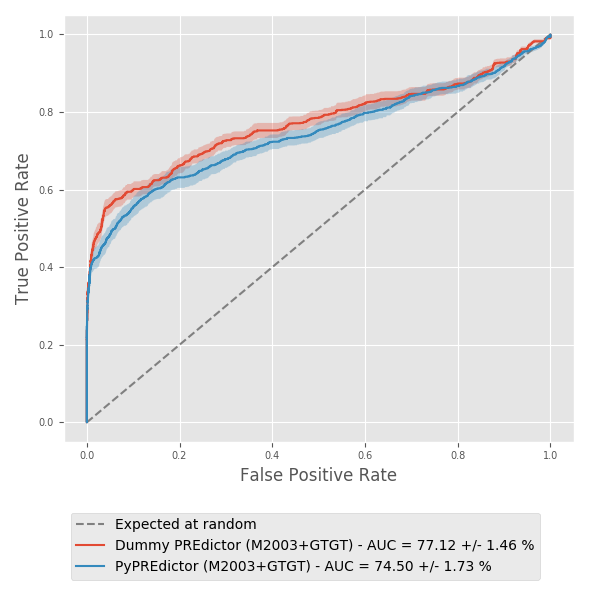

In [24]:
CV = nc.crossvalidate([
        DummyPREdictor,
        PyPREdictor
    ],
    trainingSet = trainingSet,
    validationSet = Kahn2014Seq.label(nc.positive) + DummyPREs.label(nc.negative),
    ratioTrainTest = 0.6875, # This ratio is chosen in order to give the same ratio as in Bredesen et al. 2019,
                             # for generalization comparable with Figure 1C
    ratioNegPos = 100.)

CV

#### Support Vector Machines

Support Vector Machines (SVMs) are a popular machine learning method. We will here train a *k*-spectrum SVM and a *k*-spectrum mismatch SVM using the SVM implementation from Scikit-learn. For the SVM kernel, we will use a linear kernel and also a quadratic kernel (polynomial degree 2), the latter of which can model motif pairing.

Gnocis includes two wrappers for the Scikit-learn SVM: one using the standard calculation implemented in Scikit-learn, and one using CUDA.

**Optional:** Run *either* the step below **Option A** *or* the one below **Option B**.

**Option A)** SVM using CUDA – recommended when an NVidia GPU is available, for optimal efficiency

**Note:** The following step requires that Scikit-learn **and** CUDA and CuPy are installed.

In [25]:
import gnocis.sklearnCUDAModels as sklcunc

lspectrumSVM = nc.kSpectrum(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklcunc.CUDASVM(kDegree = 1, C = 1,
                             labelPositive = nc.positive,
                             labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'SVM (linear, 5-spectrum)')

spectrumSVM = nc.kSpectrum(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklcunc.CUDASVM(kDegree = 2, C = 1,
                             labelPositive = nc.positive,
                             labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'SVM (quadratic, 5-spectrum)')

mismatchSVM = nc.kSpectrumMM(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklcunc.CUDASVM(kDegree = 2, C = 1,
                             labelPositive = nc.positive,
                             labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'SVM (quadratic, 5-spectrum mismatch)')

**Option B)** SVM using calculation implemented in Scikit-learn

**Note:** The following step requires that Scikit-learn is installed.

In [ ]:
import gnocis.sklearnModels as sklnc

lspectrumSVM = nc.kSpectrum(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklnc.SVM(kDegree = 1, C = 1,
                       labelPositive = nc.positive,
                       labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'SVM (linear, 5-spectrum)')

spectrumSVM = nc.kSpectrum(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklnc.SVM(kDegree = 2, C = 1,
                       labelPositive = nc.positive,
                       labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'SVM (quadratic, 5-spectrum)')

mismatchSVM = nc.kSpectrumMM(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklnc.SVM(kDegree = 2, C = 1,
                       labelPositive = nc.positive,
                       labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'SVM (quadratic, 5-spectrum mismatch)')

**Optional** We also benchmark the runtime performance of SVM application with a single CPU core, multiple cores and the GPU.

**Note:** The following step requires that Scikit-learn **and** CUDA and CuPy are installed.

In [26]:
import gnocis.sklearnModels as sklnc
import time
import datetime

# Train single-CPU SVM
mismatchSVM_SingleCPU = nc.kSpectrumMM(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklnc.SVM(kDegree = 2, C = 1, labelPositive = nc.positive, labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'Single')
mismatchSVM_SingleCPU = mismatchSVM_SingleCPU.train(CV.cvtrain[0])
mismatchSVM_SingleCPU.enableMultiprocessing = False

# Train multi-CPU SVM
mismatchSVM_MultiCPU = nc.kSpectrumMM(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklnc.SVM(kDegree = 2, C = 1, labelPositive = nc.positive, labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'Multiprocessing')
mismatchSVM_MultiCPU = mismatchSVM_MultiCPU.train(CV.cvtrain[0])

# Train GPU SVM
mismatchSVM_CUDA = nc.kSpectrumMM(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklcunc.CUDASVM(kDegree = 2, C = 1, labelPositive = nc.positive, labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'CUDA')
mismatchSVM_CUDA = mismatchSVM_CUDA.train(CV.cvtrain[0])

# Apply and time the different implementations
def timerun(func):
    t0 = time.time()
    func()
    return str(datetime.timedelta(seconds = time.time() - t0))

nc.nctable('Running times', [
    {
        'Name': model.name,
        'Time': str(timerun( lambda: model.score(DummyGenomic) ))
    }
    for model in [
        mismatchSVM_SingleCPU,
        mismatchSVM_MultiCPU,
        mismatchSVM_CUDA,
    ]
])

0,Single,0:11:21.608992
1,Multiprocessing,0:06:04.159367
2,CUDA,0:01:26.940460


#### Progressive addition of new models to cross-validation runs

New models can be progressively added to a Gnocis cross-validation. This facilitates the progressive testing and visualization of the  generalization of alternative model formulations.

**Optional:** We add the SVMs to our previous cross-validation (requires that **Option A/B** above has been executed).

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 1000
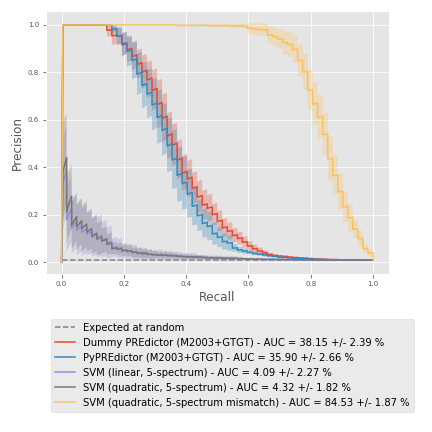
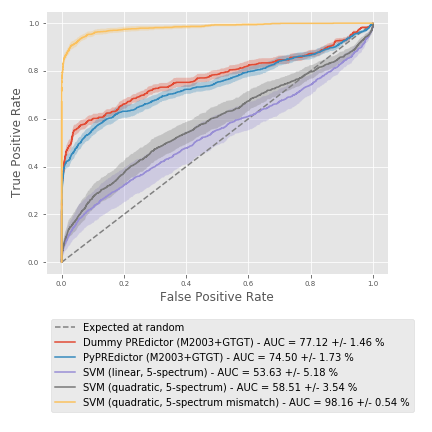

In [27]:
CV.addModel(lspectrumSVM)
CV.addModel(spectrumSVM)
CV.addModel(mismatchSVM)
CV

#### Neural Networks

Convolutional Neural Networks (CNNs) can learn local features and combine them into predictive models. CNNs have been highly successful for image recognition. In the case of one-hot encoded DNA sequences, each convolution corresponds to a learnt Position Weight Matrix. Gnocis implements support for CNNs by integrating with TensorFlow. Gnocis presents a Convolutional Network Architecture called Deep-MOCCA, which is similar in structure to SVM-MOCCA (local pairing of motifs and dinucleotide features). We will train a four-class Deep-MOCCA model with 25 convolutions of length 10, and we add it to our cross-validation.

**Optional:** This step requires that TensorFlow is installed.

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 1000
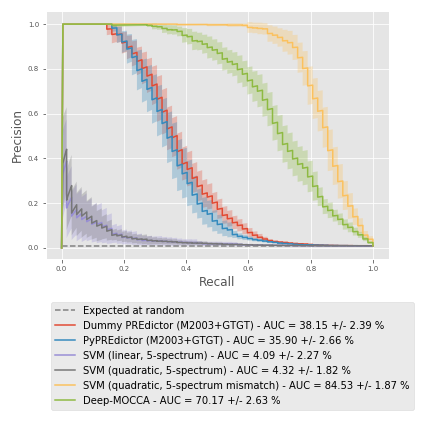
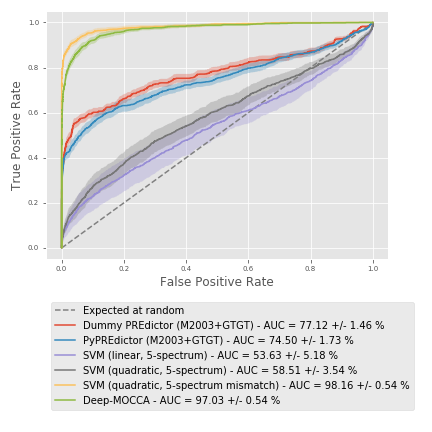

In [28]:
import gnocis.tfModels as tfnc
tfnc.setSeed(12345)
DeepMOCCA = tfnc.sequenceModelDeepMOCCA(
            name = 'Deep-MOCCA',
            windowSize = 500, windowStep = 250,
            nConv = 25, convLen = 10,
            epochs = 350,
            targetLabel = nc.positive,
            labels = [ nc.positive, labelDummyPRE, labelCDS, labelNonPcG ] )

CV.addModel(DeepMOCCA)
CV

In addition, we will train a more traditional multi-layer CNN, specified directly with Keras.

**Optional**: This step requires that TensorFlow is installed.

In [29]:
import tensorflow as tf
from tensorflow import keras

labels = [ nc.positive, labelDummyPRE, labelCDS, labelNonPcG ]

def modelConstructor():
    I = keras.Input(shape = (None, 1, 4))

    nConv = 25
    convLen = 3
    scaleFac = 2

    # First convolutional layer
    C1 = keras.layers.Conv2D(nConv, kernel_size = (convLen, 1),
                                  activation = 'relu',
                                  data_format = "channels_last")(I)
    # Scale down
    DS1 = keras.layers.AveragePooling2D((scaleFac, 1))(C1)

    # Second convolutional layer
    C2 = keras.layers.Conv2D(nConv, kernel_size = (convLen, 1),
                                  activation = 'relu',
                                  data_format = "channels_last")(DS1)
    # Scale down
    DS2 = keras.layers.AveragePooling2D((scaleFac, 1))(C2)

    # Third convolutional layer
    C3 = keras.layers.Conv2D(nConv, kernel_size = (convLen, 1),
                                  activation = 'relu',
                                  data_format = "channels_last")(DS2)
    # Scale down
    DS3 = keras.layers.AveragePooling2D((scaleFac, 1))(C3)

    # Fourth convolutional layer
    C4 = keras.layers.Conv2D(nConv, kernel_size = (convLen, 1),
                                  activation = 'relu',
                                  data_format = "channels_last")(DS3)
    # Scale down
    DS4 = keras.layers.AveragePooling2D((scaleFac, 1))(C4)

    # Finally, pool globally
    Pool = keras.layers.GlobalMaxPooling2D(data_format = "channels_last")(DS4)
    
    # ... and predict labels with a dense layer
    Term = keras.layers.Dense(len(labels), activation=tf.nn.softmax)(Pool)

    model = keras.Model(I, Term)
    
    return model

modelConstructor().summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, None, 1, 4)]      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, None, 1, 25)       325       
_________________________________________________________________
average_pooling2d_20 (Averag (None, None, 1, 25)       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, None, 1, 25)       1900      
_________________________________________________________________
average_pooling2d_21 (Averag (None, None, 1, 25)       0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, None, 1, 25)       1900      
_________________________________________________________________
average_pooling2d_22 (Averag (None, None, 1, 25)       0  

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 1000
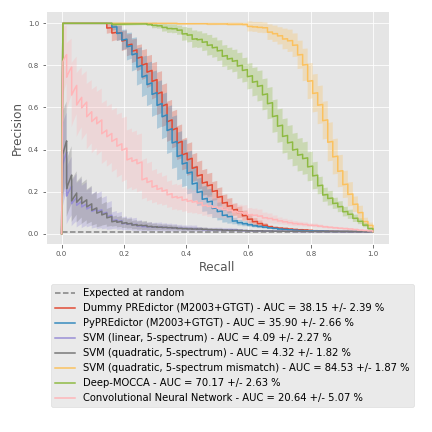
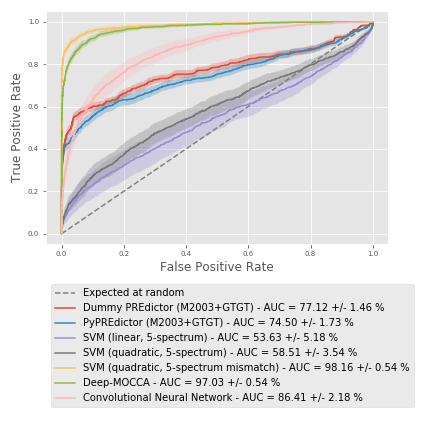

In [30]:
import gnocis.tfModels as tfnc
tfnc.setSeed(12345)
CNN = tfnc.sequenceModelKeras(
            name = 'Convolutional Neural Network',
            windowSize = 500, windowStep = 250,
            epochs = 350,
            targetLabel = nc.positive,
            labels = labels,
            modelConstructor = modelConstructor)

CV.addModel(CNN)
CV

#### Implementing new models – An applied example with XGBoost

The end-user may wish to implement new methods for modelling regulatory element sequences. Additionally, APIs may evolve, which can render the wrappers implemented in Gnocis obsolete. New methods or wrappers can be implemented for Gnocis by writing a class that inherits from the Gnocis `baseModel` (for feature-based modelling) or `sequenceModel` (for more general modelling) classes.

As an applied example, we here implement an integration for the XGBoost machine learning package using the `baseModel` class.

**Optional:** The steps in this sub-section require that XGBoost is installed (see https://xgboost.readthedocs.io/en/latest/build.html).

XGBoost uses its own `DMatrix` class for data. We can convert Gnocis features to a `DMatrix` by first mapping our features to a Pandas DataFrame or to a Numpy array. We here convert to a Numpy array.

In [31]:
import xgboost as xgb

import numpy as np

# Get feature values
fv = nc.kSpectrum(5).get(Kahn2014Seq)

# Convert feature values to Numpy array
arr = np.array(fv)

# Construct XGBoost DMatrix from Numpy array
xgb.DMatrix(arr)

The Gnocis `baseModel` class has three main methods to implement: the constructor (`__init__`), `score` and `train`. An instance of a model is first constructed with any hyperparameters, after which the `train` method will be called one of more times with one or more training sets to train the model. The `train` method is supplied with a `trainingSet` parameter, which is a dictionary that maps sequence classes to a list of sequence feature values per sequence (list of lists).

In [32]:
class XGBModel(nc.baseModel):

    def __init__(self, model = None,
                 labelPositive = nc.positive,
                 labelNegative = nc.negative):
        # XGBoost implements its own parallelism, so disable the
        # parallelism in Gnocis for this model.
        # Also batch vectors for each call, for efficiency.
        super().__init__(enableMultiprocessing = False,
                         batchsize = 1000)
        self.labelPositive = labelPositive
        self.labelNegative = labelNegative
        self.mdl = model

    def score(self, featureVectors):
        # Convert features to Numpy array
        npfv = np.array(featureVectors)
        # Further convert to XGBoost DMatrix
        xgbfv = xgb.DMatrix(npfv)
        # Predict with model
        pred = self.mdl.predict(xgbfv)
        # Return a list of scores
        # Note: The model returns a list of singleton lists of scores
        return [ [ p ] for p in pred ]

    def train(self, trainingSet):
        # Get the feature values and classes
        fvPos = trainingSet[self.labelPositive]
        fvNeg = trainingSet[self.labelNegative]
        clsPos = [ 1 ] * len(fvPos)
        clsNeg = [ 0 ] * len(fvNeg)
        # Make the Numpy arrays for the feature values and classes
        npfv = np.array(fvPos + fvNeg)
        npcls = np.array(clsPos + clsNeg)
        # Make the DMatrix
        dmat = xgb.DMatrix(npfv, label = npcls)
        # Set XGBoost parameters
        param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
        param['nthread'] = 4
        param['eval_metric'] = 'auc'
        # Train model
        rounds = 10
        mdl = xgb.train(param, dmat, rounds)
        # Return trained instance, including the trained model
        return XGBModel(
            model = mdl,
            labelPositive = self.labelPositive,
            labelNegative = self.labelNegative)

We can now define our XGBoost model in terms of features and the `XGBModel` class defined above, supplied to the `model` method of a feature network node. We will again use a set of all 5-mers as our features.

In [33]:
xgbModel = nc.kSpectrum(5) \
    .scale() \
    .window(size = 500, step = 250) \
    .model(XGBModel(labelPositive = nc.positive,
                    labelNegative = labelDummyPRE)) \
    .sequenceModel(name = 'XGBoost')

Now, we can train and apply our model.

In [34]:
# Make a training set
tpos = trainingSet.withLabel(nc.positive).sample(50)
tneg = trainingSet.withLabel(labelDummyPRE).sample(50)
tset = tpos + tneg

# Train the model
trainedXGBModel = xgbModel.train(tset)

trainedXGBModel.score(Kahn2014Seq, asTable = True)

0,2L:4289..7288 (+),0.9517
1,2L:593634..596633 (+),0.9984
2,2L:1642904..1645903 (+),0.8699
3,2L:1971529..1974528 (+),0.8688
4,2L:2447154..2450153 (+),0.9638
...,...,...
191,3R:2658822...6591228 (+),0.9515
192,3R:2659713...6600136 (+),0.9948
193,3R:2660622...6609226 (+),0.8381
194,3R:2673673...6739736 (+),0.9975
195,3R:2688682...6889821 (+),0.9002


We can also add our model to the cross-validation.

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 1000
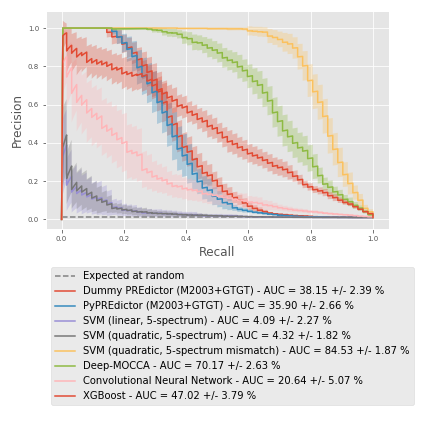
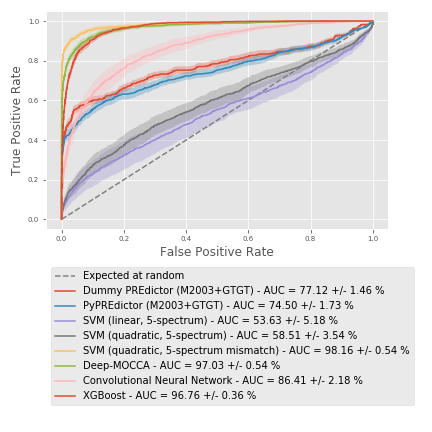

In [35]:
CV.addModel(xgbModel)
CV

#### Cross-validation with more classes

So far, we have only cross-validated our models with a single class of negatives. Cross-validating our models with additional classes can yield a more realistic indication of the true model generalization.

First, for cleaner output, we will remove a subset of models from our cross-validation.

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 1000
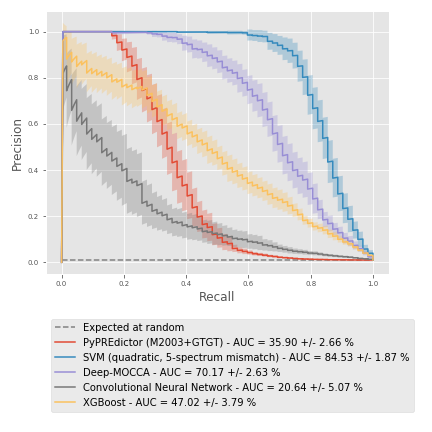
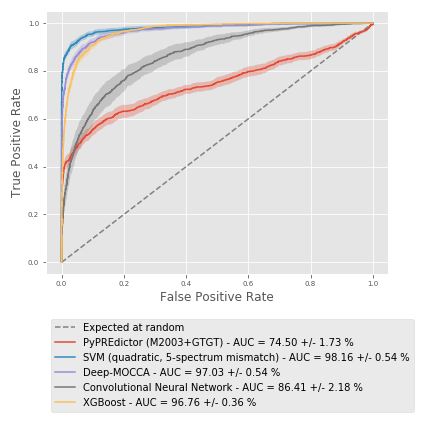

In [36]:
allModels = CV.models
CV.models = [
    mdl for mdl in CV.models
    if mdl.name in [
        'PyPREdictor (M2003+GTGT)',
        'SVM (quadratic, 5-spectrum mismatch)',
        'XGBoost',
        'Convolutional Neural Network',
        'Deep-MOCCA',
    ]
]
CV

We now apply our models for cross-validation with PREs versus coding sequences.

Cross-validation
 - Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; S

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Training set:                                                                                                                                                                                                                                                                                                                                                                                                                     Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 831769172> + CDS windows(3000/3000) + Regions set: Windows (Window size: 3000 bp; step size: 250 bp) () (PcG LBME) not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.g
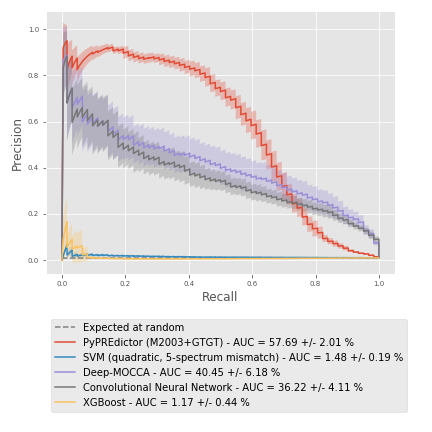
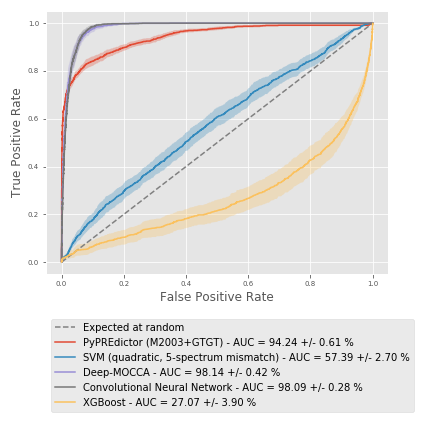

In [37]:
valSet = Kahn2014Seq.label(nc.positive) + CDSFragments.label(nc.negative)

CVPREvsCDS = nc.crossvalidate(
    CV.models,
    trainingSet = trainingSet,
    validationSet = valSet,
    ratioTrainTest = 0.6875) # This ratio is chosen in order to give the same ratio as in Bredesen et al. 2019,
                             # for generalization comparable with Figure 1C
CVPREvsCDS

Finally, it is interesting to check how well our models distinguish PREs from random PcG-depleted genomic regions. Note that these may contain real PREs, such as due to epigenetic states where PcG is depleted in the experimental data.

Cross-validation
 - Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; S

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2899425417> + Generated set <Sequences: 19600; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) not overlapping with Region<2R:8771706..8786898 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 831769172> + CDS w
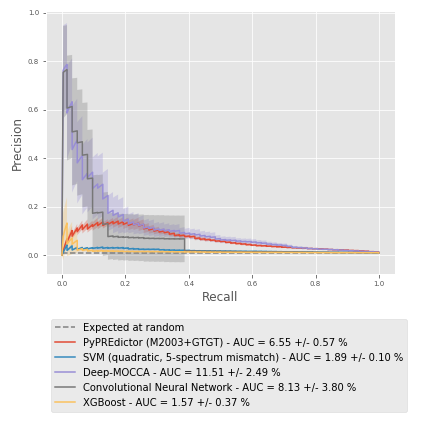
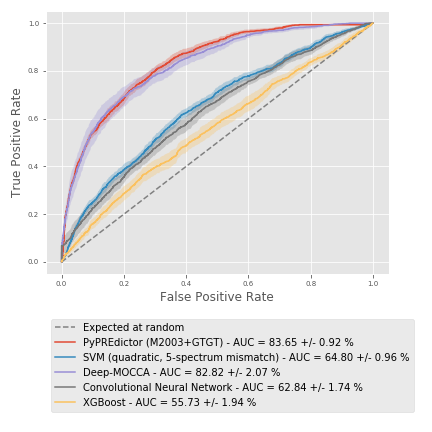

In [38]:
valSet = Kahn2014Seq.label(nc.positive) + gwWinNonPcGSeq.label(nc.negative)

CVPREvsNonPRE = nc.crossvalidate(
    CV.models,
    trainingSet = trainingSet,
    validationSet = valSet,
    ratioTrainTest = 0.6875) # This ratio is chosen in order to give the same ratio as in Bredesen et al. 2019,
                             # for generalization comparable with Figure 1C
CVPREvsNonPRE

## Genome-wide prediction

We will now apply our models for genome-wide prediction of PREs. To this end, we first train our models.

In [39]:
rep = 0
trainedModels = [
    mdl.train(CV.cvtrain[rep])
    for mdl in CV.models
]

Next, we calibrate our prediction threshold. We will use an expected precision of 80%.

In [40]:
vpos = CV.cvval[rep].withLabel(nc.positive)
for mdl in trainedModels:
    print('Calibrating model: %s'%mdl.name)
    mdl.calibrateGenomewidePrecision(positives = vpos,
                                    genome = Dmel,
                                    factor = 1. - 0.6875,
                                    precision = 0.8,
                                    bgModelOrder = 7)

Calibrating model: PyPREdictor (M2003+GTGT)
Calibrating model: SVM (quadratic, 5-spectrum mismatch)
Calibrating model: Deep-MOCCA
Calibrating model: Convolutional Neural Network
Calibrating model: XGBoost


Finally, we apply our models genome-wide for prediction. This produces a score curve and predicted candidate PREs (regions with a score above the calibrated prediction threshold).

In [41]:
modelPredictions = []

for mdl in trainedModels:
    print('Predicting with model: %s'%mdl.name)
    modelPredictions.append( mdl.predict(Dmel.sequences) )

Predicting with model: PyPREdictor (M2003+GTGT)
Predicting with model: SVM (quadratic, 5-spectrum mismatch)
Predicting with model: Deep-MOCCA
Predicting with model: Convolutional Neural Network
Predicting with model: XGBoost


The first thing to check is how many predictions each model has made.


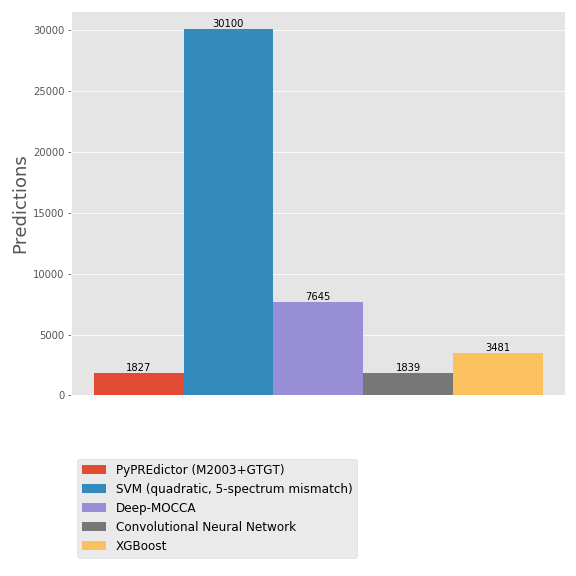

In [134]:
nc.predictionBarplot(predictionSets = [
        pred.regions().rename(mdl.name)
        for mdl, pred in zip(trainedModels, modelPredictions)
    ])

For validation of predictions, we will consider another set of experimentally determined Polycomb target sites, published by Enderle *et al.* (2011).

In [50]:
Enderle2011Rgn = nc.loadGFF('Enderle2011.GFF')
Enderle2011Rgn

0,2L,66586,67573,+,988
1,2L,87183,87594,+,412
2,2L,107802,108476,+,675
3,2L,128496,129665,+,1170
4,2L,131694,132321,+,628
...,...,...,...,...,...
2260,X,21889857,21890350,+,494
2261,X,21893107,21893670,+,564
2262,X,21954333,21955067,+,735
2263,X,22054197,22054680,+,484
2264,X,22114283,22114724,+,442


We left out PREs at the *invected* locus. We now plot this region, including the Kahn *et al.* PREs there.


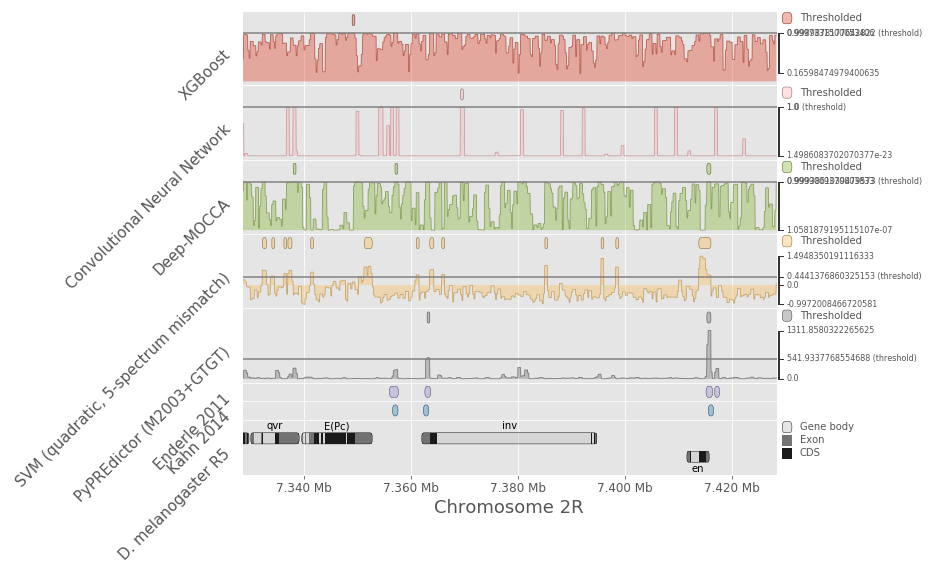

In [73]:
nc.plotGenomeTracks(
    [
        Dmel,
        Kahn2014Rgn.rename('Kahn 2014'),
        Enderle2011Rgn.rename('Enderle 2011'),
    ] + [
        pred.rename(mdl.name)
        for mdl, pred in zip(trainedModels, modelPredictions)
    ],
    invectedProximal[0].seq,
    invectedProximal[0].start,
    invectedProximal[0].end)


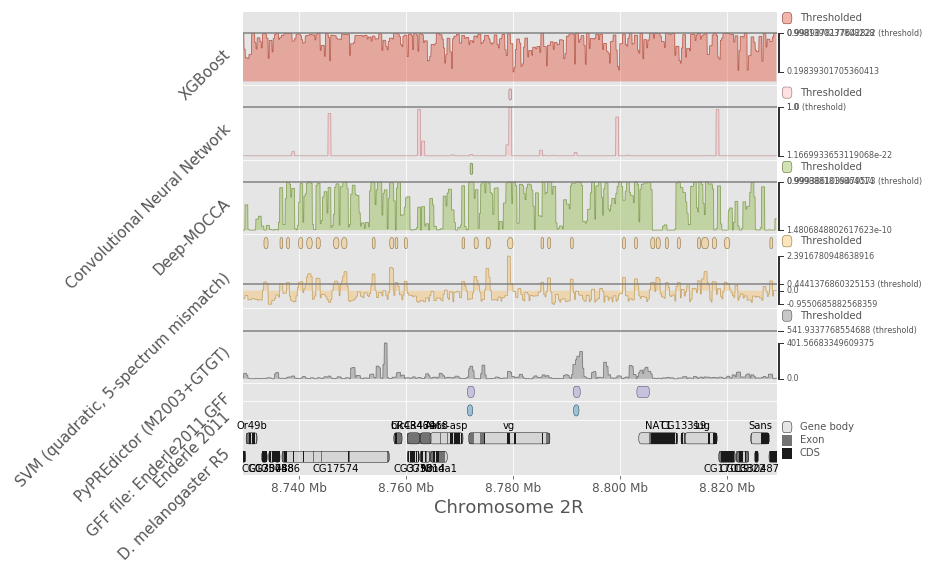

In [74]:
nc.plotGenomeTracks(
    [
        Dmel,
        Kahn2014Rgn.rename('Enderle 2011'),
        Enderle2011Rgn,
    ] + [
        pred.rename(mdl.name)
        for mdl, pred in zip(trainedModels, modelPredictions)
    ],
    vestigialProximal[0].seq,
    vestigialProximal[0].start,
    vestigialProximal[0].end)

It is interesting to check how well our models predict PREs outside of the training set on a larger scale. To this end, we check the overlap of our predictions with the Enderle *et al.* (2011) PREs, with the Kahn *et al.* (2014) PREs excluded.

In [56]:
KahnProximal = Kahn2014Rgn.deltaResize(1000).flatten()


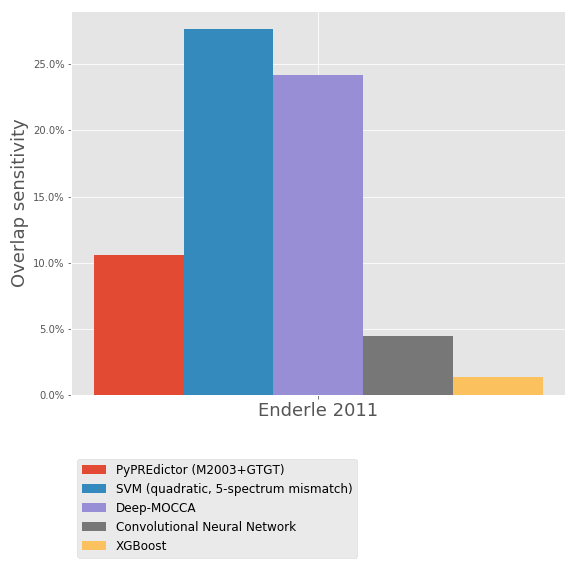

In [70]:
nc.overlapSensitivityBarplot(regionSets = [
        Enderle2011Rgn.nonOverlap(KahnProximal).rename('Enderle 2011'),
    ], predictionSets = [
        pred.regions().nonOverlap(KahnProximal).rename(mdl.name)
        for mdl, pred in zip(trainedModels, modelPredictions)
    ])


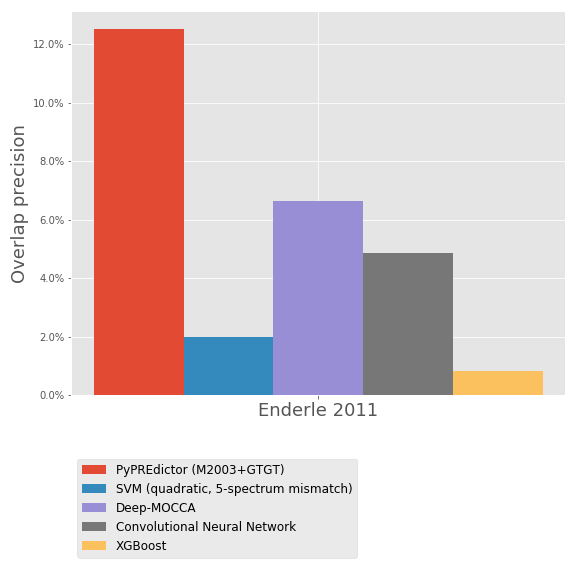

In [69]:
nc.overlapPrecisionBarplot(regionSets = [
        Enderle2011Rgn.nonOverlap(KahnProximal).flatten().rename('Enderle 2011'),
    ], predictionSets = [
        pred.regions().nonOverlap(KahnProximal).rename(mdl.name)
        for mdl, pred in zip(trainedModels, modelPredictions)
    ])

It is also interesting to check what fraction of our predictions overlap with at least one PcG signal.


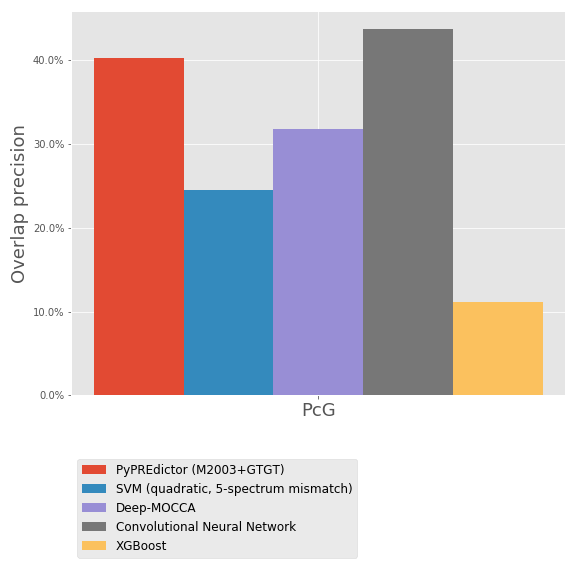

In [63]:
nc.overlapPrecisionBarplot(regionSets = [
        PcG.HBMEs(gwWin, threshold = 1).rename('PcG'),
    ], predictionSets = [
        pred.regions().rename(mdl.name)
        for mdl, pred in zip(trainedModels, modelPredictions)
    ])